In [5]:
%matplotlib inline

In [6]:
import h5py
import numpy as np
from skimage.morphology import disk
from skimage import io, img_as_ubyte
import matplotlib.pyplot as plt
from skimage.filters import sobel, median
from skimage.morphology import disk
from skimage.exposure import equalize_hist
from skimage.feature import blob_dog
from math import *
from scipy.ndimage import gaussian_filter
import itertools as itt
from numpy import arccos
import math
from math import sqrt, hypot, log
import os

In [ ]:
with h5py.File('Data_Kevin.hdf5', 'w') as f:
    for n in range(8):
        image =np.load("second_bis{}.npz".format(n+1))  
        dset = f.create_dataset('Data_{}'.format(n), data = image['data'], shape=image['data'].data.shape, chunks=True)

In [ ]:
with h5py.File('Data_Kevin.hdf5', 'r')  as f:
    img = np.concatenate((f['Data_0'][:,:,2,:], f['Data_1'][:,:,2,:], f['Data_2'][:,:,2,:]), axis=2)
    print(img.shape)

In [ ]:
with h5py.File('Data_Kevin.hdf5', 'a') as f:
    g = f['Analysis']
    g.create_dataset('stack_data_Red', data = img, shape=img.data.shape, chunks=True)

In [ ]:
img_average = np.mean(img, axis = 2).astype('uint16')
with h5py.File('Data_Kevin.hdf5', 'a') as f:
    g = f['Analysis']  
    g.create_dataset('img_averaged_Red', data = img_average, shape=img_average.data.shape, chunks=True)

In [ ]:
img_median = median(img_average, disk(500))
with h5py.File('Data_Kevin.hdf5', 'a') as f:
    g = f['Analysis']  
    g.create_dataset('img_median_Red', data = img_median, shape=img_median.data.shape, chunks=True)

In [ ]:
with h5py.File('Data_Kevin.hdf5', 'r') as f:
    nx, ny, nc, nt = f['Data_0'].shape
    img_divide = np.empty([nx,ny,nt])
    for t in range(nt):
        img_divide[:,:,t] = np.divide(f['Data_0'][:,:,2,t], f['Analysis']['img_median_Red'])

In [ ]:
with h5py.File('Data_Kevin.hdf5', 'a') as f:
    g2 = f['Img_divided']
    g2.create_dataset('img_divide_data_0_Red', data = img_divide, shape=img_divide.data.shape, chunks=True)

In [3]:
with h5py.File('Data_Kevin.hdf5', 'r') as f:
    img_divide = f['Img_divided']['img_divide_data_0'][()]


In [ ]:
print(img_divide.shape)

In [ ]:
fig, (axes) = plt.subplots(1,2, figsize=(20, 8))

axes[0].imshow(img_divide[:,:,90], cmap='gray',interpolation='nearest')
axes[0].axis("off")
axes[0].autoscale_view('tight')

axes[0].plot([0,2560], [1000, 1000], 'k-', color='r')
axes[1].plot(img_divide[1000,:,90])
axes[1].autoscale_view('tight')

In [4]:
def find_max(image, x):
    J = np.zeros(image.shape, dtype=bool)
    J[1:-1,1:-1,x] = ((image[1:-1,1:-1,x] > image[ :-2, :-2,x]) & (image[1:-1,1:-1,x] > image[ :-2, 1:-1,x]) & (image[1:-1,1:-1,x] > image[ :-2,2:,x]) &
                      (image[1:-1,1:-1,x] > image[1:-1, :-2,x]) &                                      (image[1:-1,1:-1,x] > image[1:-1,2:,x]) &
                      (image[1:-1,1:-1,x] > image[2:  , :-2,x]) & (image[1:-1,1:-1,x] > image[2:  , 1:-1,x]) & (image[1:-1,1:-1,x] > image[2:  ,2:,x]))
    
    J[1:-1,1:-1,(x-1)] = ((image[1:-1,1:-1,x] > image[ :-2, :-2,(x-1)]) & (image[1:-1,1:-1,x] > image[ :-2, 1:-1,(x-1)]) & (image[1:-1,1:-1,x] > image[ :-2,2:,(x-1)]) &
                      (image[1:-1,1:-1,x] > image[1:-1, :-2,(x-1)]) & (image[1:-1,1:-1,x] > image[1:-1, 1:-1,(x-1)]) & (image[1:-1,1:-1,x] > image[1:-1,2:,(x-1)]) &
                      (image[1:-1,1:-1,x] > image[2:  , :-2,(x-1)]) & (image[1:-1,1:-1,x] > image[2:  , 1:-1,(x-1)]) & (image[1:-1,1:-1,x] > image[2:  ,2:,(x-1)]))
    
    J[1:-1,1:-1,(x+1)] = ((image[1:-1,1:-1,x] > image[ :-2, :-2,(x+1)]) & (image[1:-1,1:-1,x] > image[ :-2, 1:-1,(x+1)]) & (image[1:-1,1:-1,x] > image[ :-2,2:,(x+1)]) &
                      (image[1:-1,1:-1,x] > image[1:-1, :-2,(x+1)]) & (image[1:-1,1:-1,x] > image[1:-1, 1:-1,(x+1)]) & (image[1:-1,1:-1,x] > image[1:-1,2:,(x+1)]) &
                      (image[1:-1,1:-1,x] > image[2:  , :-2,(x+1)]) & (image[1:-1,1:-1,x] > image[2:  , 1:-1,(x+1)]) & (image[1:-1,1:-1,x] > image[2:  ,2:,(x+1)]))
    
    return J[:,:,x] & J[:,:,x-1] & J[:,:,x+1]

In [5]:
def find_blob_DoG(image):

    min_sigma=5
    max_sigma=50
    sigma_ratio=1.6

    k = int(log(float(max_sigma) / min_sigma, sigma_ratio)) + 1

        # a geometric progression of standard deviations for gaussian kernels
    sigma_list = np.array([min_sigma * (sigma_ratio ** i)for i in range(k + 1)])

    gaussian_images = [gaussian_filter(image, s) for s in sigma_list]

        # computing difference between two successive Gaussian blurred images
        # multiplying with standard deviation provides scale invariance
    dog_images = [(gaussian_images[i] - gaussian_images[i + 1])* sigma_list[i] for i in range(k)]
    image_cube = np.dstack(dog_images)

    maxima = []
    for n in range(1, 4):
        maxima.append(find_max(image_cube, n))
    arr = np.array(maxima)    


    arr &= image > 0.95
    
    local_maxima = np.argwhere(np.bitwise_or.reduce(arr))
    add = np.zeros(local_maxima[:,0].shape)
    local_maxima = np.concatenate((local_maxima, add[:,np.newaxis]), axis=1).astype("int64")
    

    
    for blob1, blob2 in itt.combinations(local_maxima, 2):
        d = hypot(blob1[0] - blob2[0], blob1[1] - blob2[1])
        if d < 30 :
            blob2[2] = -1
           
    
    return np.array([b for b in local_maxima if b[2] >= 0])
        

In [6]:
local_maxima_me = find_blob_DoG(img_divide[:,:,0])

In [ ]:
def Num_blob(data):
    list_num_blob = []
    for t in range(nt):
        blob = find_blob_DoG(data[:,:,t])
        list_num_blob.append(len(blob))
    
    return blob, list_num_blob

In [3]:
Green = Num_blob(img_divide)

NameError: name 'Num_blob' is not defined

In [ ]:
Red = Num_blob(img_divide)

In [1]:
with open('Red.txt') as f:
    Red = f.read().splitlines()
    Red = [int(i) for i in Red]


In [2]:
with open('Green.txt') as f:
    Green = f.read().splitlines()
    Green = [int(i) for i in Green]

In [14]:
Ratio = [x/y for x, y in zip(Green, Red)]

In [15]:
y = np.array(Ratio)

In [8]:
green = np.array(Green)
red = np.array(Red)

In [16]:
x = np.arange(0, 15*len(Ratio),15)

In [104]:
z, res, _, _, _ = np.polyfit(x, y, 4, full=True)

In [105]:
print(res)

[ 24.61353361]


In [106]:
p = np.poly1d(z)

In [107]:
print(p)

           4             3             2
1.374e-11 x - 4.391e-08 x + 4.419e-05 x - 0.01481 x + 5.919


In [108]:
crit = p.deriv().r

In [109]:
r_crit = crit[crit.imag==0].real
test = p.deriv(2)(r_crit) 

In [114]:
x_max = r_crit[test<0]
y_max = p(x_min)

In [115]:
print(x_max)

[ 783.73986372]


In [ ]:
fig, (axes) = plt.subplots(1, 2, figsize=(18, 9))
fig.suptitle("First Tile",weight = "bold", fontsize=25, y = 0.96)
xp = np.linspace(0, 1440, 100)
for ax in axes:
    ax.set_xlabel("Time in min", fontsize=13)
    ax.set_ylabel("Ration Green/Red", fontsize=13)
axes[0].plot(x, y, '.', label = "Ratio Green/Red")
axes[0].plot(xp, p(xp), '-r', label = "polynomial fit")
axes[0].plot( x_max, y_max, 'o', label = "Cycle = {} hrs".format(int(x_max/60)) )
axes[0].legend(loc=0, shadow=True)
axes[1].plot(x, green, label = "Number Green Cells")
axes[1].plot(x, red, label = "Number Red Cells")
axes[1].legend(loc=7, shadow=True)
fig.savefig('Result_First_Tile.jpg')

In [ ]:
m, c = p
plt.plot(x, y, 'o', label='Original data', markersize=10)
plt.plot(x, m*x + c, 'r', label='Fitted line')


In [ ]:
with open('Red.txt', mode='wt', encoding='utf-8') as myfile:

    myfile.write('\n'.join(str(line) for line in Red))

In [ ]:
img_eq = equalize_hist(img_divide[:,:,0])

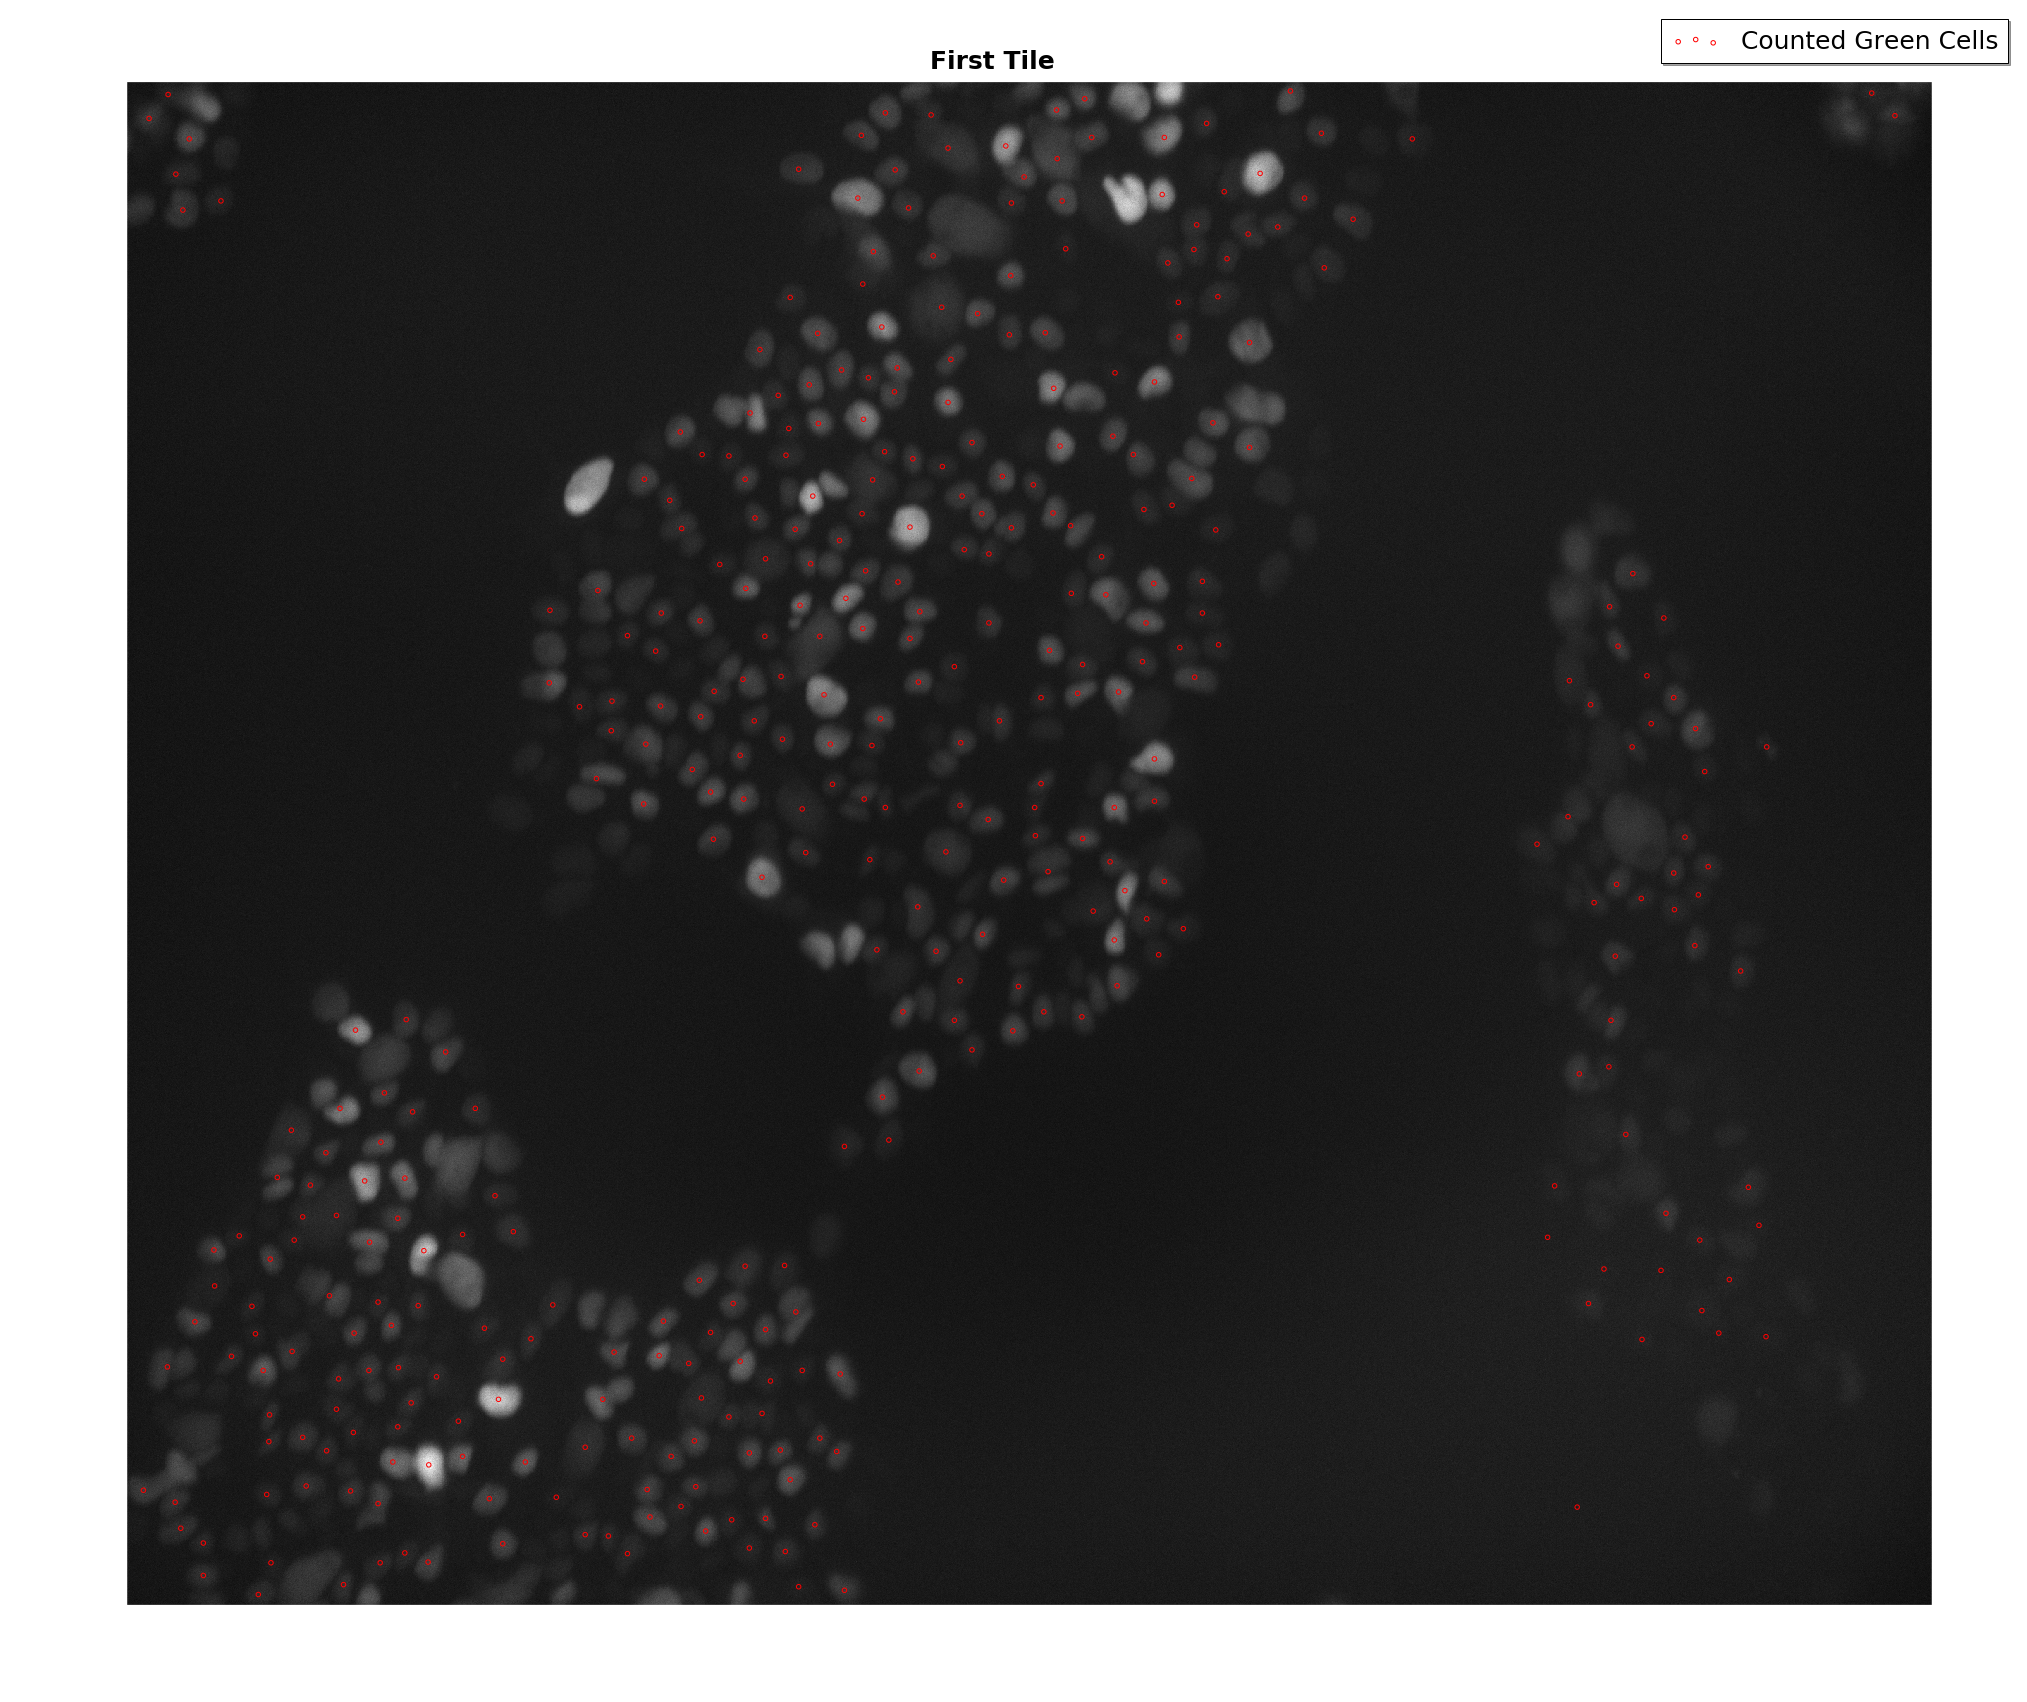

In [10]:
fig, axes = plt.subplots(1,1, figsize=(40, 30))
fig.suptitle("First Tile",weight = "bold", fontsize=25, y = 0.88)
axes.imshow(img_divide[:,:,0], cmap='gray',interpolation='nearest')
axes.scatter(local_maxima_me[:,1], local_maxima_me[:,0], marker='o', facecolors='none', edgecolors='r', label = "Counted Green Cells")
axes.legend(loc=0, fontsize=25, shadow=True)
axes.axis("off")
axes.autoscale_view('tight')
fig.savefig('Counted_cell_Green.jpg')

In [ ]:
def save_img_jpeg(image, path, **kwargs):

    timeframes = kwargs.pop('timeframes', [])
    colors = kwargs.pop('colors', [])
    
    for j in colors:
        for i in timeframes:
            img = ((image[:,:,j, i]/image[:,:,j, i].max())*255).astype("uint8")
            if j == 0:
                io.imsave("{}/BF{}.jpg".format(path, i), img)
            elif j == 1:
                io.imsave("{}/Green{}.jpg".format(path, i), img)
            elif j == 2:
                io.imsave("{}/Red{}.jpg".format(path, i), img)

In [ ]:
with h5py.File('Data_Kevin.hdf5', 'r') as f:
    timeframes = [0, 12, 24, 36, 48,60, 72, 84, 96]
    colors = [0,1,2]

    save_img_jpeg(f['Data_5'], "Tile6", colors = colors, timeframes=timeframes)